In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 23s 0us/step


In this case we are importing the model VGG16:
- weights: specifies the weight checkpoint from which to initialize the model.
- include_top: refers to including (or not) the densely connected classifier on top of the network.
- input_shape: is the shape of the image tensors that you’ll feed to the network. But this is optional, we can skip this part and the model will adapt to the input we will be using.

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map will be of size (4,4,512) so this is the one we will be build the classifier on top of. There are two ways we can proceed form this step:

### feature extraction without data augmentation

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/admin/Git/starting-keras/chapter5/all_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [27]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 917us/step - loss: 0.6445 - acc: 0.6260 - val_loss: 0.4535 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 1s 646us/step - loss: 0.4491 - acc: 0.7925 - val_loss: 0.3693 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 635us/step - loss: 0.3694 - acc: 0.8350 - val_loss: 0.3309 - val_acc: 0.8710
Epoch 4/30
2000/2000 [==============================] - 1s 645us/step - loss: 0.3258 - acc: 0.8580 - val_loss: 0.3056 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 637us/step - loss: 0.2961 - acc: 0.8710 - val_loss: 0.2878 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s 671us/step - loss: 0.2727 - acc: 0.8935 - val_loss: 0.2761 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 2s 766us/step - loss: 0.2569 - acc: 0.8975 - val_loss: 0.2683 - val_acc: 0.8950


In this case training is very fast because we are only updating the weights of two dense layers as we are using the pretained model. 

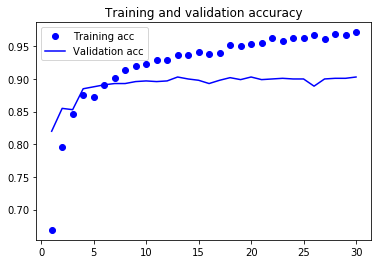

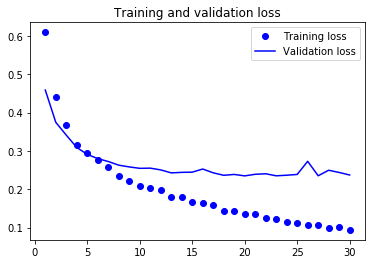

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We were able to increase the accuracy of the model but we can also see that the model is overfitting almost from the start.

### feature extraction with data augmentation 

In [28]:
from keras import models
from keras import layers

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [29]:
conv_base.trainable = False

In [30]:
len(model.trainable_weights)

4

In [31]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 304s 3s/step - loss: 0.5809 - acc: 0.7115 - val_loss: 0.4462 - val_acc: 0.8320
Epoch 2/30
 26/100 [======>.......................] - ETA: 2:25 - loss: 0.5115 - acc: 0.7654

KeyboardInterrupt: 

# Fine-tuning

Here we will keep only parte of the pre trained model frozen and we will enable the alteration of the parameters of the last layers of the model. We will be updating these layers because these represent the features that are ore specific, so in order to have a model good for our data set we want to train the more specific representation and not the more generic (lower layers).

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100


ValueError: Error when checking input: expected dense_10_input to have 2 dimensions, but got array with shape (20, 150, 150, 3)